In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def zetta(T, p0, pl, pg, L, x):
    """
    Calculate the zetta value for a given location in a membrane canal.

    This function computes the zetta value based on the pressures at different points
    of a membrane and the location within the canal.

    Parameters:
    -----------
    T : float
        The stiffness of the membrane
    p0 : float
        The pressure at the beginning of the membrane.
    pl : float
        The pressure at the end of the membrane.
    pg : float
        The outer pressure of the membrane.
    L : float
        The length of the membrane.
    x : float
        The location in the canal for which to calculate zetta.

    Returns:
    --------
    float
        The calculated zetta value at the given location.

    Notes:
    ------
    The function uses the following formula:
    zetta = 1/T * (1/2 * (pg - p0) * x**2 + pd/(6*L) * x**3 - 1/6 * (3*pg - 2*p0 - pl)* L* x)
    where pd = p0 - pl

    The constant T is not defined in the function and should be provided or defined elsewhere.

    Example:
    --------
    >>> zetta(100, 80, 120, 10, 5)
    # Returns the zetta value at the midpoint of a 10-unit long membrane
    """
    pd = p0-pl
    return 1/T * (1/2 * (pg - p0) * x**2 + pd/(6*L) * x**3 - 1/6 * (3*pg - 2*p0 - pl)* L * x )

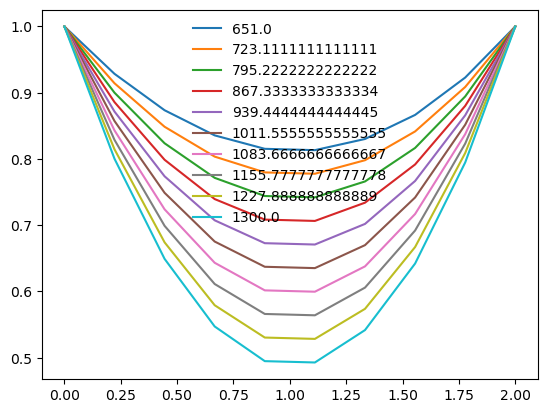

0.0 2.0


In [62]:
#zetta(T, p0, pl, pg, L, x):
for i in np.linspace(651,1300,10):
    x = np.linspace(0,2,10)
    memb = zetta(1000, 330, 220, i, 2, x)
    memb += 1
    plt.plot(x,memb,label=f"{i}")
plt.legend(frameon=False)
plt.show()

print(x[0], x[-1])

In [9]:
"""def zetta(T, p0, pl, pg, L, x):
    pd = p0-pl
    return 1/T * (1/2 * (pg - p0) * x**2 + pd/(6*L) * x**3 - 1/6 * (3*pg - 2*p0 - pl)* L * x )"""

def define_membrane(factory, begin, end, l1, lc1,L):
    x = np.linspace(0,2,100)
    memb = -zetta(1, 1.2553851318e+03, 6.2760372899e+02, .8553851318e+03, 2, x)*.01
    memb += 1
    memb = memb.round(3)
    startpoint = L/2-L/10
    lines = []
    points = []
    points.append(begin)
    for i in range(len(x)):
        new_point = factory.addPoint(startpoint + x[i], memb[i], 0, lc1)
        points.append(new_point)
        lines.append(factory.addLine(points[-2], points[-1]))
    lines.append(factory.addLine(points[-1],end))
    return lines, points

import gmsh
H=1
L=10
r=.3
Ox=1.5
lc=.1
model_rank = 0
infl, outfl, upper, lower = [],[],[],[]
gmsh.initialize()
gmsh.model.add("canal")
#gmsh.option.setNumber("Geometry.Tolerance", 1e-8)
#gmsh.option.setNumber("Mesh.CharacteristicLengthFactor", 1)

cm = 1 # e-02 # not needed for our sim
h1 = H * cm
l1 = L * cm
r = r * cm
Lc1 = lc

# We start by defining some points and some lines. To make the code shorter we
# can redefine a namespace:
factory = gmsh.model.occ
model = gmsh.model

lowerleft = factory.addPoint(0, 0, 0, Lc1)
lowerright = factory.addPoint(l1, 0, 0, Lc1)
upperright = factory.addPoint(l1, h1 , 0, Lc1)
upperleft = factory.addPoint(0, h1, 0, Lc1)

begin = factory.addPoint(Ox-L/10, h1, 0, Lc1)
end = factory.addPoint(Ox+L/10, h1, 0, Lc1)

inflow_line = factory.addLine(lowerleft, upperleft)
upper_wall_left = factory.addLine(upperleft, begin)
upper_wall_right = factory.addLine(end, upperright)
lower_wall = factory.addLine(upperright, lowerright)
outflow_line = factory.addLine(lowerright, lowerleft)

# add obstacle form
lines, points = define_membrane(factory, begin, end, l1, Lc1, L)

# Define the outer curve loop
o_loop = factory.addCurveLoop([inflow_line, upper_wall_left, *lines,
                              upper_wall_right, outflow_line, lower_wall])

# Create the plane surface with a hole
surface = factory.addPlaneSurface([o_loop])
factory.synchronize()
upper = model.addPhysicalGroup(dim=1, tags=[upper_wall_left, *lines, upper_wall_right],tag=1,name="upper_wall")
outfl = model.addPhysicalGroup(dim=1, tags=[outflow_line], tag=2, name="outflow")
infl = model.addPhysicalGroup(dim=1, tags=[inflow_line], tag=3, name="inflow")
lower = model.addPhysicalGroup(dim=1, tags=[lower_wall], tag=4, name="lower_wall")



gmsh.model.mesh.setTransfiniteCurve(upper_wall_right, 4000)
gmsh.model.mesh.setTransfiniteCurve(upper_wall_left, 4000)
gmsh.model.mesh.setTransfiniteCurve(outflow_line, 1000)
gmsh.model.mesh.setTransfiniteCurve(inflow_line, 1000)
gmsh.model.mesh.setTransfiniteCurve(lower_wall, 10000)

gmsh.model.addPhysicalGroup(dim=2, tags=[surface], tag=5, name="Domain")
factory.synchronize()
gmsh.option.setNumber("Mesh.ElementOrder", 1)
gmsh.option.setNumber("Mesh.RecombineAll", 0)
gmsh.model.mesh.generate(2)
gmsh.write("mesh.msh")
#infl = comm.bcast(infl, root=0)
#outfl = comm.bcast(outfl, root=0)
#upper = comm.bcast(upper, root=0)
#lower = comm.bcast(lower, root=0)
#gmsh.model = comm.bcast(gmsh.model, root=0)
#mesh, ct, ft = gmshio.model_to_mesh(gmsh.model, comm, model_rank,gdim=2)
#return mesh, ct, ft, infl, outfl, upper, lower

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 10%] Meshing curve 7 (Line)
Info    : [ 10%] Meshing curve 8 (Line)
Info    : [ 10%] Meshing curve 9 (Line)
Info    : [ 10%] Meshing curve 10 (Line)
Info    : [ 10%] Meshing curve 11 (Line)
Info    : [ 20%] Meshing curve 12 (Line)
Info    : [ 20%] Meshing curve 13 (Line)
Info    : [ 20%] Meshing curve 14 (Line)
Info    : [ 20%] Meshing curve 15 (Line)
Info    : [ 20%] Meshing curve 16 (Line)
Info    : [ 20%] Meshing curve 17 (Line)
Info    : [ 20%] Meshing curve 18 (Line)
Info    : [ 20%] Meshing curve 19 (Line)
Info    : [ 20%] Meshing curve 20 (Line)
Info    : [ 20%] Meshing curve 21 (Line)
Info    : [ 20%] Meshing curve 22 (Line)
Info    : [ 30%] Meshing curve 23 (Line)
Info    : [ 30%] Meshing curve 24 (Line)
I

In [4]:
gmsh.finalize()

In [11]:
gmsh.model.addPhysicalGroup?

Signature: gmsh.model.addPhysicalGroup(dim, tags, tag=-1, name='')
Docstring:
gmsh.model.addPhysicalGroup(dim, tags, tag=-1, name="")

Add a physical group of dimension `dim', grouping the model entities with
tags `tags'. Return the tag of the physical group, equal to `tag' if `tag'
is positive, or a new tag if `tag' < 0. Set the name of the physical group
if `name' is not empty.

Return an integer.

Types:
- `dim': integer
- `tags': vector of integers
- `tag': integer
- `name': string
File:      ~/.local/lib/python3.12/site-packages/gmsh.py
Type:      function

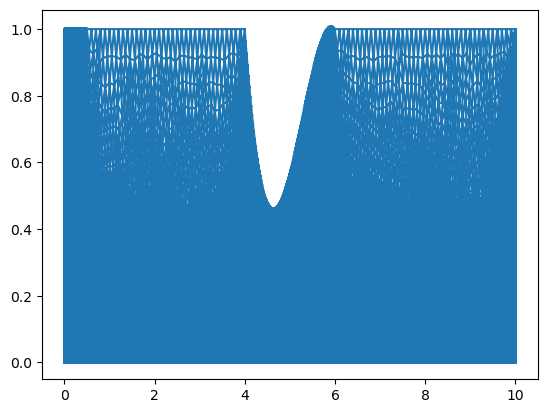

In [12]:
import matplotlib.pyplot as plt

# Get mesh data
nodes = gmsh.model.mesh.getNodes()
elements = gmsh.model.mesh.getElements()

# Extract 2D triangular elements
triangles = elements[2][1].reshape(-1, 3) - 1
x = nodes[1].reshape(-1, 3)[:, 0]
y = nodes[1].reshape(-1, 3)[:, 1]

# Plot the mesh
plt.figure()
plt.triplot(x, y, triangles)
#plt.ylim(-.1,1.1)
#plt.xlim(3,7)
#plt.axis('equal')
plt.savefig("mesh.pdf", dpi=300)
plt.show()


In [21]:
for i in range(60,53,-1):
    print(i)

60
59
58
57
56
55
54


In [63]:
np.linspace(55, 65, 9, endpoint=True)

array([55.  , 56.25, 57.5 , 58.75, 60.  , 61.25, 62.5 , 63.75, 65.  ])